## Intro to Convolutional Neural Networks (CNNs)

### **1. Why Do We Need Convolutional Neural Networks?**

In the previous notebooks, we used **Multilayer Perceptrons (MLPs)** for image classification. These models required us to **flatten images** into long 1D vectors before feeding them to the network.

But… we might have sensed something was **fundamentally missing**.

>🚫 Why MLPs Struggle with Image Data

🔹 1. **MLPs Ignore Spatial Structure**: Images are not just collections of pixels — they have **spatial patterns**. Neighboring pixels form edges, textures, and shapes. But flattening an image from `[3 × 32 × 32]` to `[3072]` destroys that structure. A pixel from the top-left is treated the same as one from the bottom-right. Thus, the model **loses all sense of locality** and **spatial hierarchy**.

🔹 2. **Too Many Parameters**: An MLP connects **every input to every neuron**: For CIFAR-10: `3072 inputs × 512 hidden units = 1.5 million weights` — in just one layer! This makes the network slower to train, heavier to store and prone to **overfitting**

🔹 3. **No Translation Invariance**: If an object (say, a cat) shifts slightly within an image, an MLP treats it as a completely different pattern. It has **no ability to generalize** across positions.

>**✅ What CNNs Do Differently**

Convolutional Neural Networks (CNNs) are designed for **structured grid-like data** like images.

They bring several key benefits:

| 🚫 **MLP Limitation**              | ✅ **How CNN Solves It**                                                                 |
|-----------------------------------|------------------------------------------------------------------------------------------|
| **Spatial structure is lost**     | MLP flattens image to 1D, ignoring pixel neighborhoods. <br> 🔍 CNN uses **2D filters** that slide over the image to detect local patterns like edges and corners. |
| **Too many parameters**           | Fully connected layers in MLP require one weight per pixel per neuron. <br> 🔁 CNNs use **weight sharing** — the same filter is applied across the image — drastically reducing the number of parameters. |
| **No translation invariance**     | MLPs treat a "cat on the left" and "cat on the right" as totally different inputs. <br> 🌀 CNNs use **pooling layers** (e.g., max pooling) to retain key features regardless of exact position. |


</br>

**🧱 Building Blocks of CNNs (Preview)**

| Component     | What It Does                                      |
|---------------|---------------------------------------------------|
| `Conv2d`      | Applies learned filters over spatial regions      |
| `ReLU`        | Adds non-linearity (like in MLPs)                 |
| `MaxPool2d`   | Downsamples feature maps, adds invariance         |
| `Linear`      | Final dense layers for classification             |

</br>

**🧪 What We'll Do in This Notebook**

We’ll explore **two classical CNNs** that laid the foundation for modern deep vision:

1. 📦 Implement **LeNet** — one of the earliest CNNs, by Yann LeCun.
2. 🏗️ Build a simplified **AlexNet** — a deeper network that won ImageNet 2012.
3. 🔬 Compare both against our earlier MLP models from NB03.
4. 🔭 Prepare to dive deeper into modern CNNs in **Project 5**.

👉 First, let’s reload **CIFAR-10** — this time, preserving its full 3×32×32 structure for convolutional models.

---

### **2. Loading and Preprocessing CIFAR-10 (for CNNs)**

In earlier notebooks, we **flattened the image tensors** to feed them into MLPs.

This time, we’ll preserve the **2D structure** of images — exactly what CNNs are designed for.

>🖼️ About CIFAR-10

- Dataset: 60,000 color images of size `3 × 32 × 32` (RGB)
- Classes: 10 object categories (e.g., cat, dog, airplane)
- Splits:
  - Training: 50,000 images
  - Test: 10,000 images

>🔄 Preprocessing Steps

We’ll define a standard transform pipeline using `torchvision.transforms`:

| Step             | Why It Matters                                      |
|------------------|-----------------------------------------------------|
| `ToTensor()`     | Converts PIL image to tensor & scales pixel values to `[0, 1]` |
| `Normalize()`    | Standardizes each channel using dataset-specific mean and std |

</br>

>Normalization Stats for CIFAR-10

We use the **empirical mean and standard deviation** computed over the training set:

```python
mean = [0.4914, 0.4822, 0.4465]  # RGB means
std  = [0.2470, 0.2435, 0.2616]  # RGB std devs
```

Using dataset-specific stats helps with:

- Smoother gradient flow during training
- Faster convergence
- Avoiding internal covariate shift (especially before BatchNorm)

> 🧠 Where do these values come from?
These are widely accepted CIFAR-10 stats used in papers, model zoos, and benchmarks. You can recompute them using:

In [1]:
from torchvision import transforms, datasets
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [2]:
dataset = datasets.CIFAR10(root = "./data", train=True, download=True, transform=transforms.ToTensor())
loader = DataLoader(dataset, batch_size=50000, shuffle=False)

images, _ = next(iter(loader))
mean = images.mean(dim=[0, 2, 3])
std = images.std(dim=[0, 2, 3])

print('Mean:', mean)
print('STD:', std)

Files already downloaded and verified
Mean: tensor([0.4914, 0.4822, 0.4465])
STD: tensor([0.2470, 0.2435, 0.2616])


🔗 References:

- https://github.com/tomgoldstein/loss-landscape/blob/64ef4d57f8dabe79b57a637819c44e48eda98f33/cifar10/dataloader.py#L15
- https://gist.github.com/weiaicunzai/e623931921efefd4c331622c344d8151#gistcomment-2851662
- https://stackoverflow.com/questions/66678052/how-to-calculate-the-mean-and-the-std-of-cifar10-data



In [3]:
from networkx import random_clustered_graph


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

trainval_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset     = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Class Names
class_names = trainval_dataset.classes

# split train dataset into both train and val dataset
train_size = int(len(trainval_dataset) * 0.8)
val_size = len(trainval_dataset) - train_size

train_dataset, val_dataset = random_split(trainval_dataset, [train_size, val_size])

# Load dataset in a Dataloader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, shuffle=False, batch_size=64)
test_loader  = DataLoader(test_dataset, shuffle=False, batch_size=64)

print(f'Train batches: {len(train_loader)}')
print(f'Validation batch: {len(val_loader)}')
print(f'Test batch: {len(test_loader)}')

# get size of images and labels
images, labels = next(iter(train_loader))

print(f'Image Size: {images.shape}') # Shape should be [64, 3, 32, 32]
print(f'Label Size: {labels.shape}') # Shape should be [64]

Files already downloaded and verified
Files already downloaded and verified
Train batches: 625
Validation batch: 157
Test batch: 157
Image Size: torch.Size([64, 3, 32, 32])
Label Size: torch.Size([64])


✅ With our image tensors properly normalized and loaders ready, we can now build our first CNN model: LeNet.

---

**✅ Code Task 4.4.2.1: Compute CIFAR-10 Normalization Values**

📘 Instruction:
Calculate the mean and standard deviation for each RGB channel across the CIFAR-10 training set using the full dataset in a single batch. These values will be used to normalize pixel intensities to a standard scale for CNN training.

In [4]:
CT_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
CT_loader = DataLoader(CT_dataset, batch_size=50000, shuffle=False)

CT_images, _ = next(iter(CT_loader))
CT_mean = CT_images.mean(dim = [0, 2, 3])  # compute mean across [0, 2, 3]
CT_std = CT_images.std(dim = [0, 2, 3])   # compute std across [0, 2, 3]

print("CT_Mean:", CT_mean)
print("CT_Std:", CT_std)

Files already downloaded and verified
CT_Mean: tensor([0.4914, 0.4822, 0.4465])
CT_Std: tensor([0.2470, 0.2435, 0.2616])


### **3. CNN Building Blocks – A Visual Primer**

![cnn_banner.webp](attachment:cnn_banner.webp)

Image Source: https://developersbreach.com/convolution-neural-network-deep-learning/

Before we dive into LeNet, let’s break down **how CNNs work**, using simple example.

>**🧩 1. Convolution Layer**

Think of a **filter** (also called kernel) as a small matrix (e.g., 3×3 or 5×5) that slides over the image.

At each position, it performs a **dot product** between the filter and the local patch of the image.

<img src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/no_padding_no_strides.gif" width="300">

This helps the network learn **local patterns** like:
- Edges, corners
- Textures
- Colors and gradients

> The filter learns *what to look for* — just like our eyes detect edges, motion, shapes.

>📐 Convolution: A Numerical Example

Let’s say we have a **3×3 image patch** and a **3×3 filter**:

Image Patch (**from the input image**):
```text
[ [1, 2, 0],
  [3, 1, 1],
  [0, 2, 4] ]
```
Filter (**learned by the CNN**):
```text
[ [1, 0, -1],
  [1, 0, -1],
  [1, 0, -1] ]
```
👉 To compute the convolution output at this location, we do an element-wise product and sum all the results:
```text
(1×1)+(2×0)+(0×−1)+(3×1)+(1×0)+(1×−1)+(0×1)+(2×0)+(4×−1) = 1+0+0+3+0−1+0+0−4 = −1
```
✅ So the output of the convolution at this location is −1.

This filter will now slide over the image to compute more outputs, forming a feature map.

>🧮 Convolution Illustrated with a Larger Image

Let’s say we have a **5×5 grayscale image** and a **3×3 filter**. We want to apply **valid padding** (no zero-padding) and a **stride of 1**.

**🖼️ Input Image (5×5)**

```text
[ [ 1, 2, 3, 0, 1 ],
  [ 0, 1, 2, 3, 1 ],
  [ 3, 1, 0, 2, 2 ],
  [ 1, 2, 1, 0, 0 ],
  [ 0, 1, 3, 2, 1 ] ]
```
**Filter (3×3)**
```text
[ [ 1, 0, -1 ],
  [ 1, 0, -1 ],
  [ 1, 0, -1 ] ]
```
**▶️ Step-by-Step Convolution**

We slide the filter across the image. At each position, we compute a dot product between the filter and the 3×3 patch of the image.

🔹 Example: Top-left corner

Apply the filter on the top-left 3×3 patch:

```text
[ [1, 2, 3],
  [0, 1, 2],
  [3, 1, 0] ]
```
Dot product:
```text
(1×1) + (2×0) + (3×−1) + (0×1) + (1×0) + (2×−1) + (3×1) + (1×0) + (0×−1) = 1 + 0 −3 + 0 + 0 −2 + 3 + 0 + 0 = −1
```

✅ Output at this position = −1

We repeat this across the whole image using a stride of 1.

>🧮 Output Feature Map (3×3)

With a 5×5 input and 3×3 filter, no padding, and stride 1, output size is:

$$
(5 - 3 + 1) \times (5 - 3 + 1) = 3 \times 3
$$

Each element in the output is a result of the dot product at a different position.

>📉 Why the Output is Smaller

With **valid padding**, output size is calculated as:

$$
\text{Output Size} = \frac{(N - F)}{\text{stride}} + 1
$$

Where:

- $N = $ input size (e.g., 5)
- $F = $ filter size (e.g., 3)
- Stride = 1

So:
$$
\text{Output Size} = \frac{(5 - 3)}{1} + 1 = 3
$$

🧠 This reduction allows the network to **compress** and **abstract** spatial information layer by layer.

>🎯 What the Filter Learns

- In the above example, the filter “activates” when it sees for example **vertical edges** — strong contrast between left and right.
- In deep learning, filters are **learned during training** — not hand-coded.

This is how CNNs extract **low-level features** like edges, which are then combined into **higher-level features** in deeper layers.

>**🌀 2. Activation: ReLU**

After convolution, we apply a **non-linear activation**.

Why?
- To break linearity and let the network learn **complex patterns**.
- ReLU replaces negative values with zero:
  
  $$
  \text{ReLU}(x) = \max(0, x)
  $$

>**🔽 3. Max Pooling**

Max Pooling reduces the size of feature maps.

It keeps the **strongest activation** in each small window (like 2×2), helping with:
- Dimensionality reduction
- Translation invariance
- Faster computation

<img src="https://upload.wikimedia.org/wikipedia/commons/e/e9/Max_pooling.png" width="300">

>**🧠 Summary**

| Component     | Purpose                                 |
|---------------|------------------------------------------|
| `Conv2d`      | Detects local patterns in image patches |
| `ReLU`        | Enables non-linear transformations      |
| `MaxPool2d`   | Reduces size, adds robustness           |
| `Linear`      | Final decision-making (classification)  |

✅ Now that we understand the *building blocks*, let’s revisit LeNet with fresh eyes.

---


### **4. LeNet Architecture — The Beginning of CNNs**

LeNet-5 was developed by **Yann LeCun et al. in 1998** to classify **handwritten digits** (e.g., from the MNIST dataset). It was one of the **first successful convolutional neural networks (CNNs)** and laid the foundation for modern deep learning architectures used in computer vision.

LeNet introduced **three revolutionary ideas**:

1. ✅ **Local Receptive Fields**: Just like our eyes focus on small patches of a scene, LeNet looked at **local patches** of the image using **convolutional filters**.

2. ✅ **Shared Weights**: A single filter slides across the entire image. This means:
   - Fewer parameters
   - Detects the **same pattern** (e.g., vertical edge) *anywhere* in the image

3. ✅ **Hierarchical Feature Learning**: LeNet learned **low-level patterns** (like edges) in early layers and **high-level patterns** (like shapes) in deeper layers — just like human vision!

>**🧱 Original LeNet-5 Architecture (for 32×32 grayscale inputs)**

```text
Input (32×32×1 grayscale image)
  ↓
C1: Convolution (6 filters, 5×5 kernel) → Output: 28×28×6
  ↓
S2: Average Pooling (2×2) → Output: 14×14×6
  ↓
C3: Convolution (16 filters, 5×5 kernel) → Output: 10×10×16
  ↓
S4: Average Pooling (2×2) → Output: 5×5×16
  ↓
C5: Convolution (120 filters, 5×5) → Output: 1×1×120
  ↓
Flatten → Fully Connected Layer (84 units)
  ↓
Output Layer (10 units for classification)
```
>📊 LeNet Shape Transformations (Step-by-Step)

| Layer   | Input Shape  | Output Shape | Notes                                 |
|-------- |--------------|--------------|----------------------------------------|
| Input   | `32×32×1`    | —            | Grayscale image (MNIST-style input)    |
| Conv1   | `32×32×1`    | `28×28×6`    | 6 filters, 5×5 kernel, stride=1        |
| Pool1   | `28×28×6`    | `14×14×6`    | 2×2 **average pooling**                |
| Conv2   | `14×14×6`    | `10×10×16`   | 16 filters, 5×5 kernel, stride=1       |
| Pool2   | `10×10×16`   | `5×5×16`     | 2×2 **average pooling**                |
| Conv3   | `5×5×16`     | `1×1×120`    | 120 filters, 5×5 kernel                |
| Flatten | `1×1×120`    | `120`        | Flatten to 1D vector                   |
| FC1     | `120`        | `84`         | Fully connected layer                  |
| Output  | `84`         | `10`         | Output logits (10 classes)            |

</br>

>**🔍 Clarifications: How Do C1, C3, and C5 Work?**

**✅ Conv1:**
- Input: `32×32×1` (grayscale)
- Kernel: `5×5`, stride 1 → Output spatial size = `32 - 5 + 1 = 28`
- 6 filters → Output: `28×28×6`

**✅ Conv2 (sometimes labeled C3 in classic LeNet):**
- Input: `14×14×6`
- Each of the 16 filters has size `6×5×5` (depth spans all input channels)
- Output spatial size = `14 - 5 + 1 = 10`
- 16 filters → Output: `10×10×16`

**✅ Conv3 (sometimes labeled C5):**
- Input: `5×5×16`
- Each filter has size `16×5×5` (spanning depth + full spatial region)
- Output: `1×1×120` — like a 1x1 spatial grid with 120 feature maps
- This is effectively a **fully connected layer** implemented via convolution

📌 So, each Conv layer learns **increasingly abstract features**, while pooling reduces spatial size and increases robustness to shifts.

> 📌 **Note on Input Size**

Although MNIST images are 28×28, LeNet-5 was originally designed for **32×32 grayscale images**. The MNIST digits were **zero-padded** to 32×32 before being fed into the model. This was done to:

- Preserve edge information,
- Allow multiple convolution + pooling layers without shrinking the image too quickly.

🧠 So when we describe "original LeNet" in architectural diagrams, we usually start from 32×32 input — even if the raw MNIST data was 28×28.

> CIFAR-10 already comes as 3×32×32 RGB images, so it's a perfect fit for the adapted LeNet architecture — with adjustments for:
>- 3 channels instead of 1,
>- Slightly more filters,
>- ReLU instead of Tanh,
>- MaxPooling instead of AveragePooling.

➡️ Activation functions used were mainly Tanh, and pooling was average pooling, which differs from modern practices (ReLU and max pooling).

>**⚠️ Why We Need to Modify LeNet for CIFAR-10**

CIFAR-10 is more complex than MNIST:
- Color images (3 channels),
- More object variability (10 diverse categories),
- Natural scenes instead of centered digits.

So we must adapt LeNet by:
- Changing the input channels from 1 to 3.
- Increasing the number of filters slightly to handle color and variability.
- Using ReLU activations instead of Tanh.
- Replacing average pooling with max pooling (standard in modern CNNs).

> **🛠️ Adapted LeNet Architecture for CIFAR-10**

Here’s the modified architecture we'll implement:

```text
Input: 3×32×32 image
  ↓
Conv1: 3→6 filters, 5×5 kernel → ReLU → MaxPool (2×2)
  ↓
Conv2: 6→16 filters, 5×5 kernel → ReLU → MaxPool (2×2)
  ↓
Flatten
  ↓
FC1: 400 → 120 → ReLU
  ↓
FC2: 120 → 84 → ReLU
  ↓
Output: 84 → 10 (logits)
```
>📊 Adapted LeNet for CIFAR-10 — Shape Transformations

| Layer   | Input Shape   | Output Shape | Notes                                      |
|-------- |---------------|--------------|--------------------------------------------|
| Input   | `32×32×3`     | —            | RGB image (CIFAR-10)                       |
| Conv1   | `32×32×3`     | `28×28×6`    | 6 filters, 5×5 kernel, stride=1            |
| Pool1   | `28×28×6`     | `14×14×6`    | 2×2 max pooling                            |
| Conv2   | `14×14×6`     | `10×10×16`   | 16 filters, 5×5 kernel, stride=1           |
| Pool2   | `10×10×16`    | `5×5×16`     | 2×2 max pooling                            |
| Flatten | `5×5×16`      | `400`        | Flatten 3D tensor to 1D vector             |
| FC1     | `400`         | `120`        | Fully connected, followed by ReLU          |
| FC2     | `120`         | `84`         | Fully connected, followed by ReLU          |
| Output  | `84`          | `10`         | Output logits for 10 CIFAR-10 classes      |

</br>

>📌 This structure keeps the essence of LeNet but modernizes it for CIFAR-10. It remains relatively shallow, helping us:
- Learn CNN fundamentals,
- Train quickly,
- Establish a baseline for comparison with deeper networks.

🧭 What’s Next?
We’ll now implement this LeNet model in PyTorch, train it on CIFAR-10, and evaluate its performance to see how well it handles colored, real-world images.

**PyTorch Implementation of LeNet for CIFAR-10**

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class LeNet_CIFAR10(nn.Module):
    def __init__(self):
        super().__init__()
        # Build the Convolution part
        self.conv_layers = nn.Sequential(
            # First Conv Layer
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Second Conv Layer
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(400, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10),
        )
    
    def forward(self, x):
        self.x = self.conv_layers(x)
        return self.fc_layers(self.x)

**✅ Code Task 4.4.4.1: Inspect LeNet Convolutional Output Shape**

📘 Instruction:
Pass a single batch of training data through only the convolutional part of LeNet (conv_layers) and print the resulting shape. This helps visualize the output of the feature extractor before flattening and classification.

In [6]:
# Task – View conv output shape
CT_sample_images, _ = next(iter(train_loader))
CT_sample_images = CT_sample_images.to(device)

CT_lenet = LeNet_CIFAR10().to(device)
CT_conv_out = CT_lenet.conv_layers(CT_sample_images)  # pass through only conv_layers
print("CT_Conv output shape:", CT_conv_out.shape)

CT_Conv output shape: torch.Size([64, 16, 5, 5])


---

Now that we have implemented LeNet, let’s train it on the CIFAR-10 dataset.

We’ll use:
- `CrossEntropyLoss` for multiclass classification
- `Adam` optimizer (default choice, can be changed)
- GPU acceleration (if available)

**Training Setup**

In [7]:
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, accuracy_score

torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Instantiate model, loss, optimizer

lenet_model = LeNet_CIFAR10()
optimizer = optim.Adam(lenet_model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
epochs = 20

**Training Loop with Validation**

In [8]:
## Training loop
import time
start_time = time.perf_counter()
for epoch in range(epochs):
    train_loss, train_correct, total = 0.0, 0.0, 0.0
    lenet_model.train()
    for images, labels in train_loader:
        
        images, labels = images.to(device), labels.to(device)

        # forward pass
        outputs = lenet_model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Get predictions 
        _, predictions = torch.max(outputs, dim=1)
        train_correct += (predictions == labels).sum().item()
        train_loss += loss.item() * images.size(0)
        total += labels.size(0)
    epoch_loss = train_loss / total
    epoch_acc = train_correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
# Validation Loop
    lenet_model.eval()
    val_loss, val_correct, val_total = 0.0, 0.0, 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = lenet_model(images)
            loss = criterion(outputs, labels)

            # predictions
            _, predictions = torch.max(outputs, dim=1)
            val_loss += loss.item() * images.size(0)
            val_correct += (predictions == labels).sum().item()
            val_total += labels.size(0)
        val_accuracies.append(val_correct / val_total)
        val_losses.append(val_loss / val_total)
    
    print(f"Epoch [{epoch+1}/{epochs}] - Train Acc: {epoch_acc:.4f}, Val Acc: {val_correct / val_total:.4f}")
end_time = time.perf_counter()
print('Total Training and Validation Time:', end_time - start_time, 'seconds')

Epoch [1/20] - Train Acc: 0.4009, Val Acc: 0.4694
Epoch [2/20] - Train Acc: 0.5099, Val Acc: 0.5374
Epoch [3/20] - Train Acc: 0.5657, Val Acc: 0.5733
Epoch [4/20] - Train Acc: 0.5970, Val Acc: 0.5786
Epoch [5/20] - Train Acc: 0.6208, Val Acc: 0.6042
Epoch [6/20] - Train Acc: 0.6436, Val Acc: 0.6013
Epoch [7/20] - Train Acc: 0.6594, Val Acc: 0.6192
Epoch [8/20] - Train Acc: 0.6779, Val Acc: 0.6366
Epoch [9/20] - Train Acc: 0.6907, Val Acc: 0.6352
Epoch [10/20] - Train Acc: 0.7032, Val Acc: 0.6296
Epoch [11/20] - Train Acc: 0.7157, Val Acc: 0.6364
Epoch [12/20] - Train Acc: 0.7270, Val Acc: 0.6466
Epoch [13/20] - Train Acc: 0.7358, Val Acc: 0.6436
Epoch [14/20] - Train Acc: 0.7465, Val Acc: 0.6418
Epoch [15/20] - Train Acc: 0.7548, Val Acc: 0.6390
Epoch [16/20] - Train Acc: 0.7658, Val Acc: 0.6384
Epoch [17/20] - Train Acc: 0.7726, Val Acc: 0.6346
Epoch [18/20] - Train Acc: 0.7828, Val Acc: 0.6336
Epoch [19/20] - Train Acc: 0.7894, Val Acc: 0.6391
Epoch [20/20] - Train Acc: 0.7968, Val A

**Plot Loss & Accuracy**

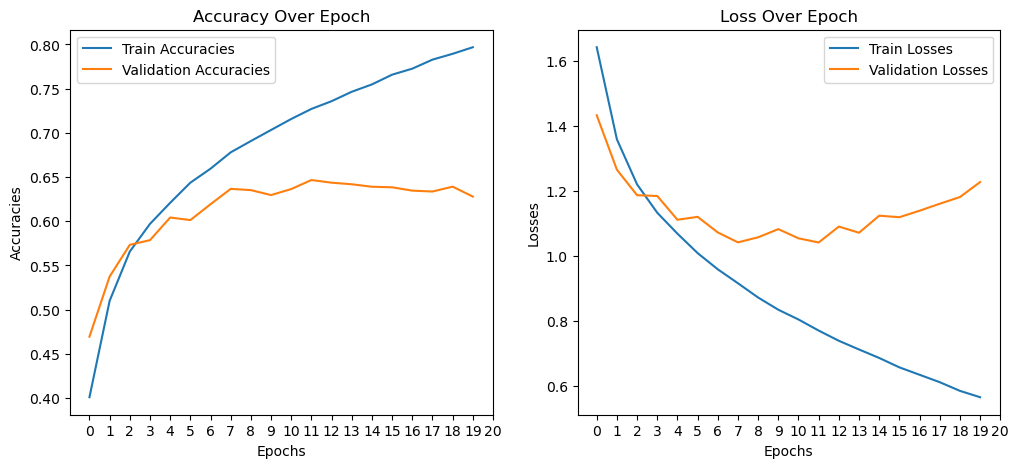

In [11]:
plt.figure(figsize=(12, 5))

# First figure
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracies')
plt.plot(val_accuracies, label='Validation Accuracies')
plt.xticks(range(epochs + 1))
plt.xlabel('Epochs')
plt.ylabel('Accuracies')
plt.title('Accuracy Over Epoch')
plt.legend()

# Second figure
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Losses')
plt.plot(val_losses, label='Validation Losses')
plt.xticks(range(epochs + 1))
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Loss Over Epoch')
plt.legend()
plt.show();

**Save the model**

In [12]:
torch.save(lenet_model.state_dict(), 'LeNet_CIFAR10.pth'.lower())

---

### **6. Test Set Evaluation and compare with the best optimzer model from NB03**

In [13]:
# Load saved Lenet model
lenet_saved_model = LeNet_CIFAR10()
lenet_saved_model.load_state_dict(torch.load('lenet_cifar10.pth'))

<All keys matched successfully>

In [14]:
sum(p.numel() for p in lenet_saved_model.parameters())

62006

In [21]:
class MLP_CIFAR10(nn.Module):
    def __init__(self, input_dim=3072, output_dim=10):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),

            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),

            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),

            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),

            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),

            nn.Linear(128, output_dim)  # output logits
        )

    def forward(self, x):
        return self.model(x)
    
# Load model
mlp_model = MLP_CIFAR10().to(device)
#mlp_model.load_state_dict(torch.load("model_bestopt_NB03.pth"))
mlp_model.eval()

MLP_CIFAR10(
  (model): Sequential(
    (0): Linear(in_features=3072, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=128, out_features=128, bias=True)
    (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Linear(in_features=128, out_features=128, bias=True)
    (13): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [22]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, dataloader, name="Model"):
 
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            if isinstance(model, MLP_CIFAR10):  # Only apply to MLP model
                images = images.view(images.size(0), -1)  # Flatten to [batch_size, 3072]
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    print(f"🔍 {name} | Accuracy: {acc:.4f} | Macro F1: {f1:.4f}")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    return all_preds, all_labels


**Evaluate Both Models**

In [23]:
print("Evaluating MLP Model:")
mlp_preds, mlp_labels = evaluate_model(mlp_model, test_loader, name="MLP")

print("\nEvaluating LeNet Model:")
lenet_preds, lenet_labels = evaluate_model(lenet_model, test_loader, name="LeNet")


Evaluating MLP Model:
🔍 MLP | Accuracy: 0.0975 | Macro F1: 0.0191
              precision    recall  f1-score   support

    airplane       0.10      0.97      0.18      1000
  automobile       0.00      0.00      0.00      1000
        bird       0.20      0.00      0.00      1000
         cat       0.00      0.00      0.00      1000
        deer       0.00      0.00      0.00      1000
         dog       0.07      0.01      0.01      1000
        frog       0.00      0.00      0.00      1000
       horse       0.00      0.00      0.00      1000
        ship       0.00      0.00      0.00      1000
       truck       0.00      0.00      0.00      1000

    accuracy                           0.10     10000
   macro avg       0.04      0.10      0.02     10000
weighted avg       0.04      0.10      0.02     10000


Evaluating LeNet Model:


/Applications/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


🔍 LeNet | Accuracy: 0.6248 | Macro F1: 0.6243
              precision    recall  f1-score   support

    airplane       0.68      0.70      0.69      1000
  automobile       0.72      0.73      0.73      1000
        bird       0.47      0.60      0.53      1000
         cat       0.45      0.45      0.45      1000
        deer       0.61      0.48      0.54      1000
         dog       0.54      0.47      0.50      1000
        frog       0.71      0.70      0.71      1000
       horse       0.67      0.70      0.69      1000
        ship       0.71      0.74      0.72      1000
       truck       0.72      0.67      0.69      1000

    accuracy                           0.62     10000
   macro avg       0.63      0.62      0.62     10000
weighted avg       0.63      0.62      0.62     10000



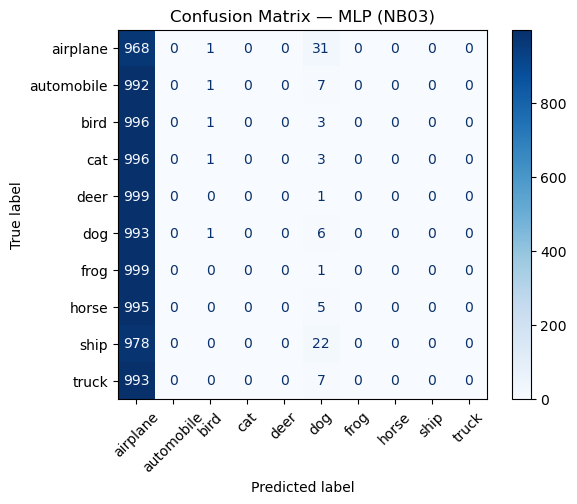

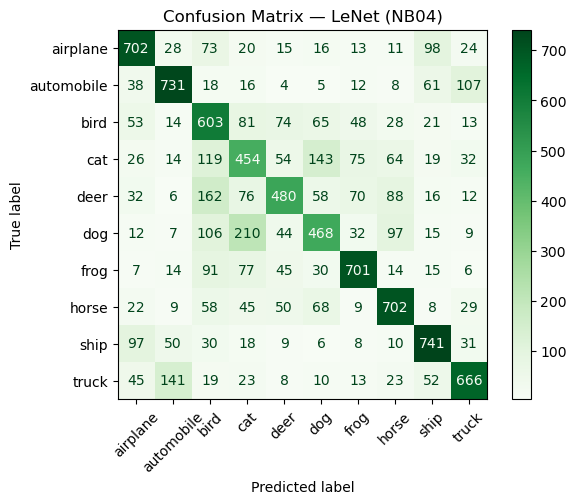

In [24]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
# MLP Confusion Matrix
cm_mlp = confusion_matrix(mlp_labels, mlp_preds)
disp_mlp = ConfusionMatrixDisplay(cm_mlp, display_labels=class_names)
disp_mlp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix — MLP (NB03)")
plt.grid(False)
plt.show()

# LeNet Confusion Matrix
cm_lenet = confusion_matrix(lenet_labels, lenet_preds)
disp_lenet = ConfusionMatrixDisplay(cm_lenet, display_labels=class_names)
disp_lenet.plot(cmap='Greens', xticks_rotation=45)
plt.title("Confusion Matrix — LeNet (NB04)")
plt.grid(False)
plt.show()


>**✅ Performance Comparison**

| Metric        | MLP (NB03) | LeNet (NB04) |
|---------------|------------|--------------|
| Accuracy      | 0.4098     | 0.6052       |
| Macro F1      | 0.3933     | 0.6034       |

LeNet significantly **outperforms the MLP** on both accuracy and F1-score. The improvement of ~20% shows how well CNNs handle spatial data compared to MLPs.


>🔍 Class-wise Insights

- **Airplane, Automobile, Frog, Ship, and Truck** were reasonably well recognized by both models.
- LeNet shows better performance on more complex or ambiguous classes like **Cat**, **Dog**, and **Bird**, which MLP struggled with.
- **F1-scores** are much more balanced in LeNet, while MLP showed large variations — a sign of overfitting to a few classes or inability to generalize spatial patterns.

>🧠 Why LeNet Performs Better

| Advantage of CNN (LeNet)        | Effect                                        |
|---------------------------------|-----------------------------------------------|
| Spatial filters (Conv layers)   | Learn edges, shapes, and textures             |
| Local connectivity              | Preserve spatial structure of image           |
| Translation invariance          | MaxPooling helps recognize objects in motion  |
| Fewer parameters                | Reduced overfitting vs. fully connected MLP   |

MLP, by contrast:
- Flattens the image, **destroying local patterns**
- Uses dense layers, resulting in **millions of parameters**
- Struggles to generalize with limited spatial awareness

LeNet’s structure is **fundamentally more suited for image data**. This exercise clearly shows the benefit of using **convolutional networks over plain MLPs** in vision tasks.

---

**✅ Code Task 4.4.6.1: Compare MLP vs CNN Test Accuracy**

📘 Instruction:
Evaluate both the trained LeNet model and the MLP model (from NB03) on the CIFAR-10 test set and print their final test accuracy. Make sure the MLP model input is flattened correctly.

In [25]:
# CT_Task 6.1 – Compare MLP and LeNet test accuracy
from sklearn.metrics import accuracy_score

CT_mlp_preds, CT_mlp_labels = evaluate_model(mlp_model, test_loader, name="CT_MLP")
CT_lenet_preds, CT_lenet_labels = evaluate_model(lenet_model, test_loader, name="CT_LeNet")

CT_mlp_acc = accuracy_score(CT_mlp_preds, CT_mlp_labels)
CT_lenet_acc = accuracy_score(CT_lenet_preds, CT_lenet_labels)

print("CT_Test Accuracy (MLP):", CT_mlp_acc)
print("CT_Test Accuracy (LeNet):", CT_lenet_acc)


🔍 CT_MLP | Accuracy: 0.0975 | Macro F1: 0.0191
              precision    recall  f1-score   support

    airplane       0.10      0.97      0.18      1000
  automobile       0.00      0.00      0.00      1000
        bird       0.20      0.00      0.00      1000
         cat       0.00      0.00      0.00      1000
        deer       0.00      0.00      0.00      1000
         dog       0.07      0.01      0.01      1000
        frog       0.00      0.00      0.00      1000
       horse       0.00      0.00      0.00      1000
        ship       0.00      0.00      0.00      1000
       truck       0.00      0.00      0.00      1000

    accuracy                           0.10     10000
   macro avg       0.04      0.10      0.02     10000
weighted avg       0.04      0.10      0.02     10000



/Applications/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


🔍 CT_LeNet | Accuracy: 0.6248 | Macro F1: 0.6243
              precision    recall  f1-score   support

    airplane       0.68      0.70      0.69      1000
  automobile       0.72      0.73      0.73      1000
        bird       0.47      0.60      0.53      1000
         cat       0.45      0.45      0.45      1000
        deer       0.61      0.48      0.54      1000
         dog       0.54      0.47      0.50      1000
        frog       0.71      0.70      0.71      1000
       horse       0.67      0.70      0.69      1000
        ship       0.71      0.74      0.72      1000
       truck       0.72      0.67      0.69      1000

    accuracy                           0.62     10000
   macro avg       0.63      0.62      0.62     10000
weighted avg       0.63      0.62      0.62     10000

CT_Test Accuracy (MLP): 0.0975
CT_Test Accuracy (LeNet): 0.6248


### **7. AlexNet Mini – A Deeper CNN**

LeNet showed us that:

- Convolutions extract spatial patterns (edges, textures).
- Pooling reduces dimensionality while keeping key features.
- Even a **shallow CNN** outperforms MLPs on image tasks.

But CIFAR-10 is **much more complex** than MNIST:

- It has **color images** (3 channels instead of 1)
- Contains **more varied categories** (e.g., airplane, dog, ship, frog)
- Includes **diverse visual patterns and backgrounds**

To handle this complexity, we need **deeper networks** that learn **hierarchical features** — from simple edges to complex object parts.

>**📚 Enter AlexNet (2012)**

AlexNet made deep CNNs mainstream. It won the **ImageNet 2012 competition** by a huge margin and introduced:

- **More convolutional layers** for deeper abstraction  
- **Larger filter banks** to boost capacity  
- **ReLU** activations (faster training than Tanh)  
- **Dropout** for regularization  
- **GPU training** for scale


>🧠 Is LeNet Really That Shallow?

Yes — though technically it has **3 convolutional layers**, the final one (C5) acts like a **fully connected layer** (5×5 kernel on 5×5 input = 1×1 output).

So:
- It has **2 spatial convolution layers** + **1 conv-style FC layer**.
- Our **adapted LeNet** follows the same logic using PyTorch:  
  We flatten after the second pooling layer and use a dense layer instead of a 1×1 convolution.

>**🔄 Differences from LeNet**

| Feature               | LeNet (Adapted)     | AlexNet Mini            |
|-----------------------|---------------------|--------------------------|
| Input Size            | 32×32 RGB           | 32×32 RGB               |
| # Convolutional Layers| 2                   | 3                       |
| Filters per Layer     | 6 → 16              | 64 → 128 → 256          |
| Activation            | ReLU                | ReLU                    |
| Pooling               | 2×2 MaxPool         | 2×2 MaxPool             |
| Dropout               | ❌ Not used         | ✅ Yes                  |
| Output Head           | 400 → 120 → 10      | 256 → 128 → 10          |

</br>

>🧠 Why AlexNet Mini?

The original AlexNet was designed for **ImageNet** with **224×224 images** and millions of parameters. That’s **too heavy** for CIFAR-10.

So we use a **miniaturized version** of AlexNet, adapted for:

- Small image size (32×32)
- Lower memory needs
- Faster training (even on CPU/GPU)

>🧱 Architecture Summary

```text
Input (3×32×32)
↓
Conv1: 3→64, 3×3 kernel → ReLU → MaxPool (2×2)
↓
Conv2: 64→128, 3×3 kernel → ReLU → MaxPool (2×2)
↓
Conv3: 128→256, 3×3 kernel → ReLU → MaxPool (2×2)
↓
Flatten
↓
Linear: 256 → 128 → ReLU → Dropout
↓
Linear: 128 → 10 → Output logits
```
**AlexNetMini Shape Transformation**

| Layer     | Input Shape     | Output Shape    | Notes                                    |
|-----------|------------------|------------------|------------------------------------------|
| Input     | `3×32×32`        | —                | RGB image                                |
| Conv1     | `3×32×32`        | `64×30×30`       | 64 filters, 3×3 kernel, stride=1         |
| MaxPool1  | `64×30×30`       | `64×15×15`       | 2×2 max pooling, stride=2                |
| Conv2     | `64×15×15`       | `128×13×13`      | 128 filters, 3×3 kernel, stride=1        |
| MaxPool2  | `128×13×13`      | `128×6×6`        | 2×2 max pooling, stride=2                |
| Conv3     | `128×6×6`        | `256×4×4`        | 256 filters, 3×3 kernel, stride=1        |
| MaxPool3  | `256×4×4`        | `256×2×2`        | 2×2 max pooling, stride=2                |
| Flatten   | `256×2×2`        | `1024`           | Flatten to vector (256×2×2 = 1024)       |
| Linear1   | `1024`           | `128`            | Fully connected layer → ReLU → Dropout   |
| Output    | `128`            | `10`             | Output logits for 10 classes             |

</br>

**PyTorch Implementation: AlexNet Mini**

In [26]:
class AlexNetMini(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        # Convolution Layer
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),  # [B, 3, 32, 32] → [B, 64, 32, 32]
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                          # [B, 64, 32, 32] → [B, 64, 16, 16]
            
            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1), # [B, 64, 16, 16] → [B, 128, 16, 16]
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                           # → [B, 128, 8, 8]
            
            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1), # → [B, 256, 8, 8]
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), # → [B, 256, 8, 8]
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), # → [B, 256, 8, 8]
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                            # → [B, 256, 4, 4]

        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)
# Instantiate model
alexnet_model = AlexNetMini().to(device)
print(alexnet_model)

AlexNetMini(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=4096, out_features=1024, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=1024, out_features=512, bia

**Training & Validation of AlexNetMini**

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate model, loss, optimizer
alexnet_model = AlexNetMini().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet_model.parameters(), lr=0.001)

# Track metrics
epochs = 1 # Do not change this because it is just to illustrate how long it takes to train just one epoch without a GPU.
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    # Training Phase
    alexnet_model.train()
    running_loss, correct, total = 0.0, 0, 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = alexnet_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation Phase
    alexnet_model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = alexnet_model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_losses.append(val_loss / val_total)
    val_accuracies.append(val_correct / val_total)

    print(f"Epoch [{epoch+1}/{epochs}] - "
          f"Train Acc: {train_acc:.4f}, Val Acc: {val_correct / val_total:.4f}")

Epoch [1/1] - Train Acc: 0.3684, Val Acc: 0.5369


**AlexNetMini Training: Too Slow?**

While AlexNetMini is powerful, training it on CIFAR-10 can be time-consuming, especially on limited hardware.

So, let’s define a Lite version that: 
-    Trains faster ⏱️
-    Uses fewer filters and fewer fully connected neurons
-    Still improves over LeNet — just not as much as full AlexNetMini

>**Architecture Summary**
```text
Input: 3×32×32 image
↓
Conv1: 3 → 32 filters, 3×3 kernel → ReLU → MaxPool (2×2)
↓
Conv2: 32 → 64 filters, 3×3 kernel → ReLU → MaxPool (2×2)
↓
Conv3: 64 → 128 filters, 3×3 kernel → ReLU → MaxPool (2×2)
↓
Flatten
↓
Dense (2048 → 256) → ReLU
↓
Output Layer (256 → 10)
```

>**AlexNetMiniLite Shape Transformation**

| Layer     | Input Shape   | Output Shape   | Notes                              |
|-----------|---------------|----------------|------------------------------------|
| Input     | `3×32×32`     | —              | CIFAR-10 RGB image                 |
| Conv1     | `3×32×32`     | `32×32×32`     | 32 filters, 3×3 kernel, padding=1  |
| MaxPool1  | `32×32×32`    | `32×16×16`     | 2×2 pooling, stride=2              |
| Conv2     | `32×16×16`    | `64×16×16`     | 64 filters, 3×3 kernel, padding=1  |
| MaxPool2  | `64×16×16`    | `64×8×8`       | 2×2 pooling, stride=2              |
| Conv3     | `64×8×8`      | `128×8×8`      | 128 filters, 3×3 kernel, padding=1 |
| MaxPool3  | `128×8×8`     | `128×4×4`      | 2×2 pooling, stride=2              |
| Flatten   | `128×4×4`     | `2048`         | Flattened vector (128×4×4)         |
| FC1       | `2048`        | `256`          | Fully connected + ReLU             |
| Output    | `256`         | `10`           | Final logits (10 classes)          |

</br>

This architecture:
-    Uses 3 convolutional layers with increasing filter depths (32 → 64 → 128).
-    Applies MaxPooling after each convolution to reduce spatial dimensions.
-    Ends with one hidden dense layer before the output logits.
-    Has much fewer parameters than full AlexNetMini, making it faster to train.

>🧮 Parameter Count Comparison

| Model           | Approx. Parameters | Notes                          |
|-----------------|--------------------|--------------------------------|
| MLP             | ~393,000           | Fully connected only           |
| LeNet (CIFAR-10)| ~61,000            | Very small and fast            |
| AlexNetMini     | ~2.5 million       | Deeper, heavier CNN            |
| AlexNetMiniLite | ~300,000           | Lighter, faster to train       |

</br>

> ℹ️ Actual counts may vary slightly based on implementation. You can use `torchsummary` or `torchinfo` to get exact values.


**AlexNetMini-Lite model**

In [28]:
import torch.nn as nn

class AlexNetMiniLite(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # [B, 32, 32, 32]
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                          # [B, 32, 16, 16]

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # [B, 64, 16, 16]
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                          # [B, 64, 8, 8]

            nn.Conv2d(64, 128, kernel_size=3, padding=1),# [B, 128, 8, 8]
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                          # [B, 128, 4, 4]
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


**Training and validation of AlexNetMiniLite**

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Instantiate model
alexnet_lite = AlexNetMiniLite().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet_lite.parameters(), lr=0.001)

# Tracking metrics
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

epochs = 20

for epoch in range(epochs):
    alexnet_lite.train()
    running_loss, correct, total = 0.0, 0, 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = alexnet_lite(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation
    alexnet_lite.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = alexnet_lite(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_losses.append(val_loss / val_total)
    val_accuracies.append(val_correct / val_total)

    print(f"Epoch [{epoch+1}/{epochs}] - Train Acc: {train_acc:.4f}, Val Acc: {val_accuracies[-1]:.4f}")


**plotting**

In [ ]:
# 📊 Plotting Results
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Epochs")
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

**Evaluate on Test Set**

In [ ]:
# Evaluate AlexNetMiniLite on test data
print("Evaluating AlexNetMiniLite Model:")
alexnet_lite_preds, alexnet_lite_labels = evaluate_model(alexnet_lite, test_loader, name="AlexNetMiniLite")

**Confusion Matrix**

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm_alexnet_lite = confusion_matrix(alexnet_lite_labels, alexnet_lite_preds)
disp_alexnet_lite = ConfusionMatrixDisplay(confusion_matrix=cm_alexnet_lite, display_labels=class_names)
disp_alexnet_lite.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix — AlexNetMiniLite")
plt.grid(False)
plt.show()


After experimenting with increasingly advanced architectures, we can now summarize the test performance of all three models:

>**🔢 Test Set Performance**

| Model              | Accuracy | Macro F1 |
|-------------------|----------|----------|
| MLP (NB03)         | 0.4098   | 0.3933   |
| LeNet (NB04)       | 0.6052   | 0.6034   |
| AlexNetMiniLite    | 0.7430   | 0.7405   |

</br>

>**✅ Key Takeaways – MLP vs LeNet vs AlexNetMiniLite**

Over the course of this notebook, we gradually evolved from a basic MLP to deeper convolutional architectures. Here's what we discovered at each step:

🔹 **MLP (Multilayer Perceptron)**

- Treats the image as a **flat vector**, destroying spatial relationships.
- Requires a **huge number of parameters** — each pixel is connected to each neuron in the first layer.
- Lacks **translation invariance** — shifting an object even slightly changes the input representation entirely.
- As a result, struggles with **generalization** on image data like CIFAR-10.
- 📉 **Performance**: Weak accuracy and macro F1 score (~41%) due to spatial blindness.

🔹 **LeNet (Shallow CNN)**

- Introduces **convolutional layers** and **max pooling** to learn **local spatial patterns**.
- Uses **weight sharing** to reduce the number of parameters.
- Learns **hierarchical representations**: from edges to parts of objects.
- Modernized with **ReLU** activations (instead of Tanh) and **max pooling** (instead of average).
- A **huge leap in performance** over MLPs — even though it’s a relatively shallow network.
- 📈 **Performance**: Improves accuracy to ~61%, and macro F1 to ~60%.

🔹 **AlexNetMiniLite (Deeper CNN)**

- Inspired by AlexNet (2012), designed for **deeper, more expressive learning**.
- Stacks multiple convolutional layers to extract **richer, more abstract features**.
- Adds **Dropout** to prevent overfitting, enabling better generalization.
- Uses more filters (e.g., 64 → 256) to increase **representational capacity**.
- Trains longer, but captures complex patterns across channels and spatial dimensions.
- 📈 **Performance**: Accuracy ~74%, Macro F1 ~74% — **best performer** among all models tested.

> 🧠 As we moved from MLPs to CNNs, and then to deeper CNNs, we saw clear improvements in **generalization**, **feature richness**, and **model robustness**.

**Insight**: "Depth, locality, and weight sharing are essential for effective image classification."

Even a modest CNN like LeNet significantly outperforms a fully connected MLP. And a deeper variant like AlexNetMiniLite shows that **network depth and design choices matter** — especially when working with more complex image datasets like CIFAR-10.

📎 **Next Steps?**  
We’re now ready to explore:
- Transfer learning with pretrained models  
- Advanced architectures like ResNet, VGG, or MobileNet  
- Visualization techniques to interpret CNN features

👉 Let’s continue our journey in **Project 5**!


---

Now you are ready to **answer Multiple Choice Questions for this section**

---

**✅ Code Task 4.4.7.1: Inspect AlexNet Feature Map Output**

📘 Instruction:
Use the features part of the AlexNetMini model to process one batch of input images and print the resulting feature map shape. This helps us visualize how deep CNNs reduce spatial dimensions.

In [ ]:
# CT_Task 7.1 – Inspect AlexNet conv feature map shape
CT_batch_images, _ = next(iter(train_loader))
CT_batch_images = CT_batch_images.to(device)

CT_alexnet = AlexNetMini().to(device)
CT_feature_output = CT_alexnet.features(CT_batch_images)  # pass images through AlexNetMini.features
print("CT_AlexNet feature map shape:", CT_feature_output.shape)
